# House Prices - Advanced Regression Techniques 

# A. Data preprocessing and EDA
### Imports packages 

In [1]:
import os
import warnings

import time

# Start counting notebook running time
time_start = time.time()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor

import optuna

# Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

sns.set()

# Mute warnings
warnings.filterwarnings('ignore')

### Import data

In [2]:
# Train data
train = pd.read_csv("train.csv", index_col="Id")
df_train = train.copy()
print('train data size: ', df_train.shape)

# Test data
test = pd.read_csv("test.csv", index_col="Id")
df_test = test.copy()
print('test data size: ', df_test.shape)

train data size:  (1460, 80)
test data size:  (1459, 79)


In [3]:
pd.set_option('display.max_columns', None) 
df_train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Check missing values (in percentage)

<Axes: ylabel='Missing values (%)'>

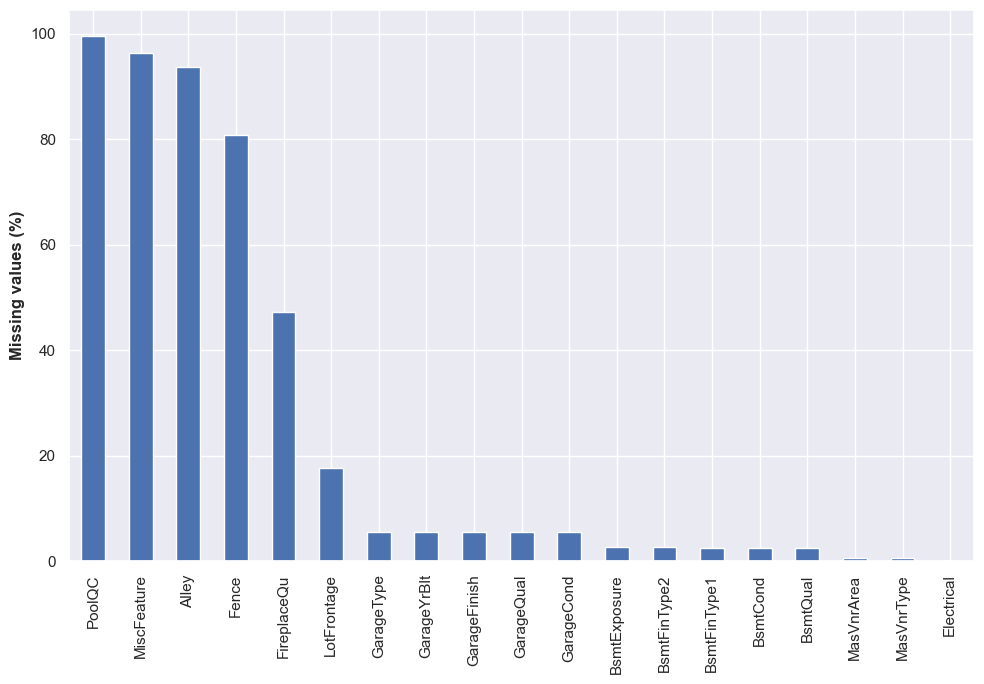

In [4]:
df_missing = df_train.isna().sum()[df_train.isna().sum() > 0].sort_values(ascending = False)/len(df_train)*100
df_missing.plot.bar(figsize = (10,7), ylabel = 'Missing values (%)')

### Clean Data

Some of the categorical features in this dataset have what are apparently typos in their categories (as we compare them to the information in data_description.txt):

In [5]:
# Construction year of the newest house
df_train.YearBuilt.max() # 2010

def clean(df):
    
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    
    # Some values of GarageYrBlt are corrupt, so we'll replace them with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    
    # Some values of YrSold are also corrupt i.e. house was sold before it was built! We'll replace them with the year the house was built
    df["YrSold"] = df["YrSold"].where(df.YrSold >= df.YearBuilt, df.YearBuilt)
    
    # Names beginning with numbers are awkward to work with
    df.rename(columns={"1stFlrSF": "FirstFlrSF",
                       "2ndFlrSF": "SecondFlrSF",
                       "3SsnPorch": "Threeseasonporch"},
              inplace=True)
    
    return df


df_train = clean(df_train)
df_test = clean(df_test)

### Categorical features: ordianl encoding

In [6]:
# Some of the categorical features are ordered so we need to correctly encode them

ordered_levels = {
    "ExterQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "ExterCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "HeatingQC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "KitchenQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "FireplaceQu": ["Po", "Fa", "TA", "Gd", "Ex"],
    "GarageQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "GarageCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "PoolQC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# add a new category 'None' in each ordinal categorical feature so that we can replace NAs with a category 'None'.
ordered_levels = {key: ["None"] + value for key, value in ordered_levels.items()} # the 1st level is 'None'

def ordinal_encode(df):
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels, ordered=True)) 
    return df

# encode ordered categorical features
df_train = ordinal_encode(df_train)

### Categorical features: nominal encoding

In [7]:
# The 'MSSubClass' is a string/unordered(nominal) categorical variable but encoded as `int` type. So we need to convert the data type. 

other_categorical_features = ['MSSubClass'] 

def nominal_encode(df):
    for name in other_categorical_features:
        df[name] = df[name].astype('str')
    return df

# encode nominal categorical features
df_train = nominal_encode(df_train)

### Handle Missing Values

In [8]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("O"):
        df[name] = df[name].fillna("None") 
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None") 
    return df

# impute NAs
df_train = impute(df_train)

# Check if there are still NAs
print(df_train.isna().sum()[df_train.isna().sum() > 0].sort_values(ascending = False))

Series([], dtype: int64)


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   object  
 1   MSZoning          1460 non-null   object  
 2   LotFrontage       1460 non-null   float64 
 3   LotArea           1460 non-null   int64   
 4   Street            1460 non-null   object  
 5   Alley             1460 non-null   object  
 6   LotShape          1460 non-null   category
 7   LandContour       1460 non-null   object  
 8   Utilities         1460 non-null   category
 9   LotConfig         1460 non-null   object  
 10  LandSlope         1460 non-null   category
 11  Neighborhood      1460 non-null   object  
 12  Condition1        1460 non-null   object  
 13  Condition2        1460 non-null   object  
 14  BldgType          1460 non-null   object  
 15  HouseStyle        1460 non-null   object  
 16  OverallQual       1460 n

### Factorize ordered categorical features with label encoding

In [10]:
def label_encode(df):
    X = df.copy()
    # The `cat.codes` attribute holds the category levels.
    for colname in X.select_dtypes(["category"]).columns:
        X[colname] = X[colname].cat.codes
    return X

df_train = label_encode(df_train)

### Numeric features

In [11]:
numeric_features = []
for feature in df_train.select_dtypes(["float64", "int64"]).drop('SalePrice', axis = 1): 
    numeric_features.append(feature)
    
print('number of numeric features: ', len(numeric_features))

number of numeric features:  35


As can be seen from the above information there are still some object/categorical data which we'll take care of later until we do some feature engineering with them! 

### Initial Analysis and Baseline Score

The plot below helps to visually understand which numerical features have a strong relationship the label Saleproice.

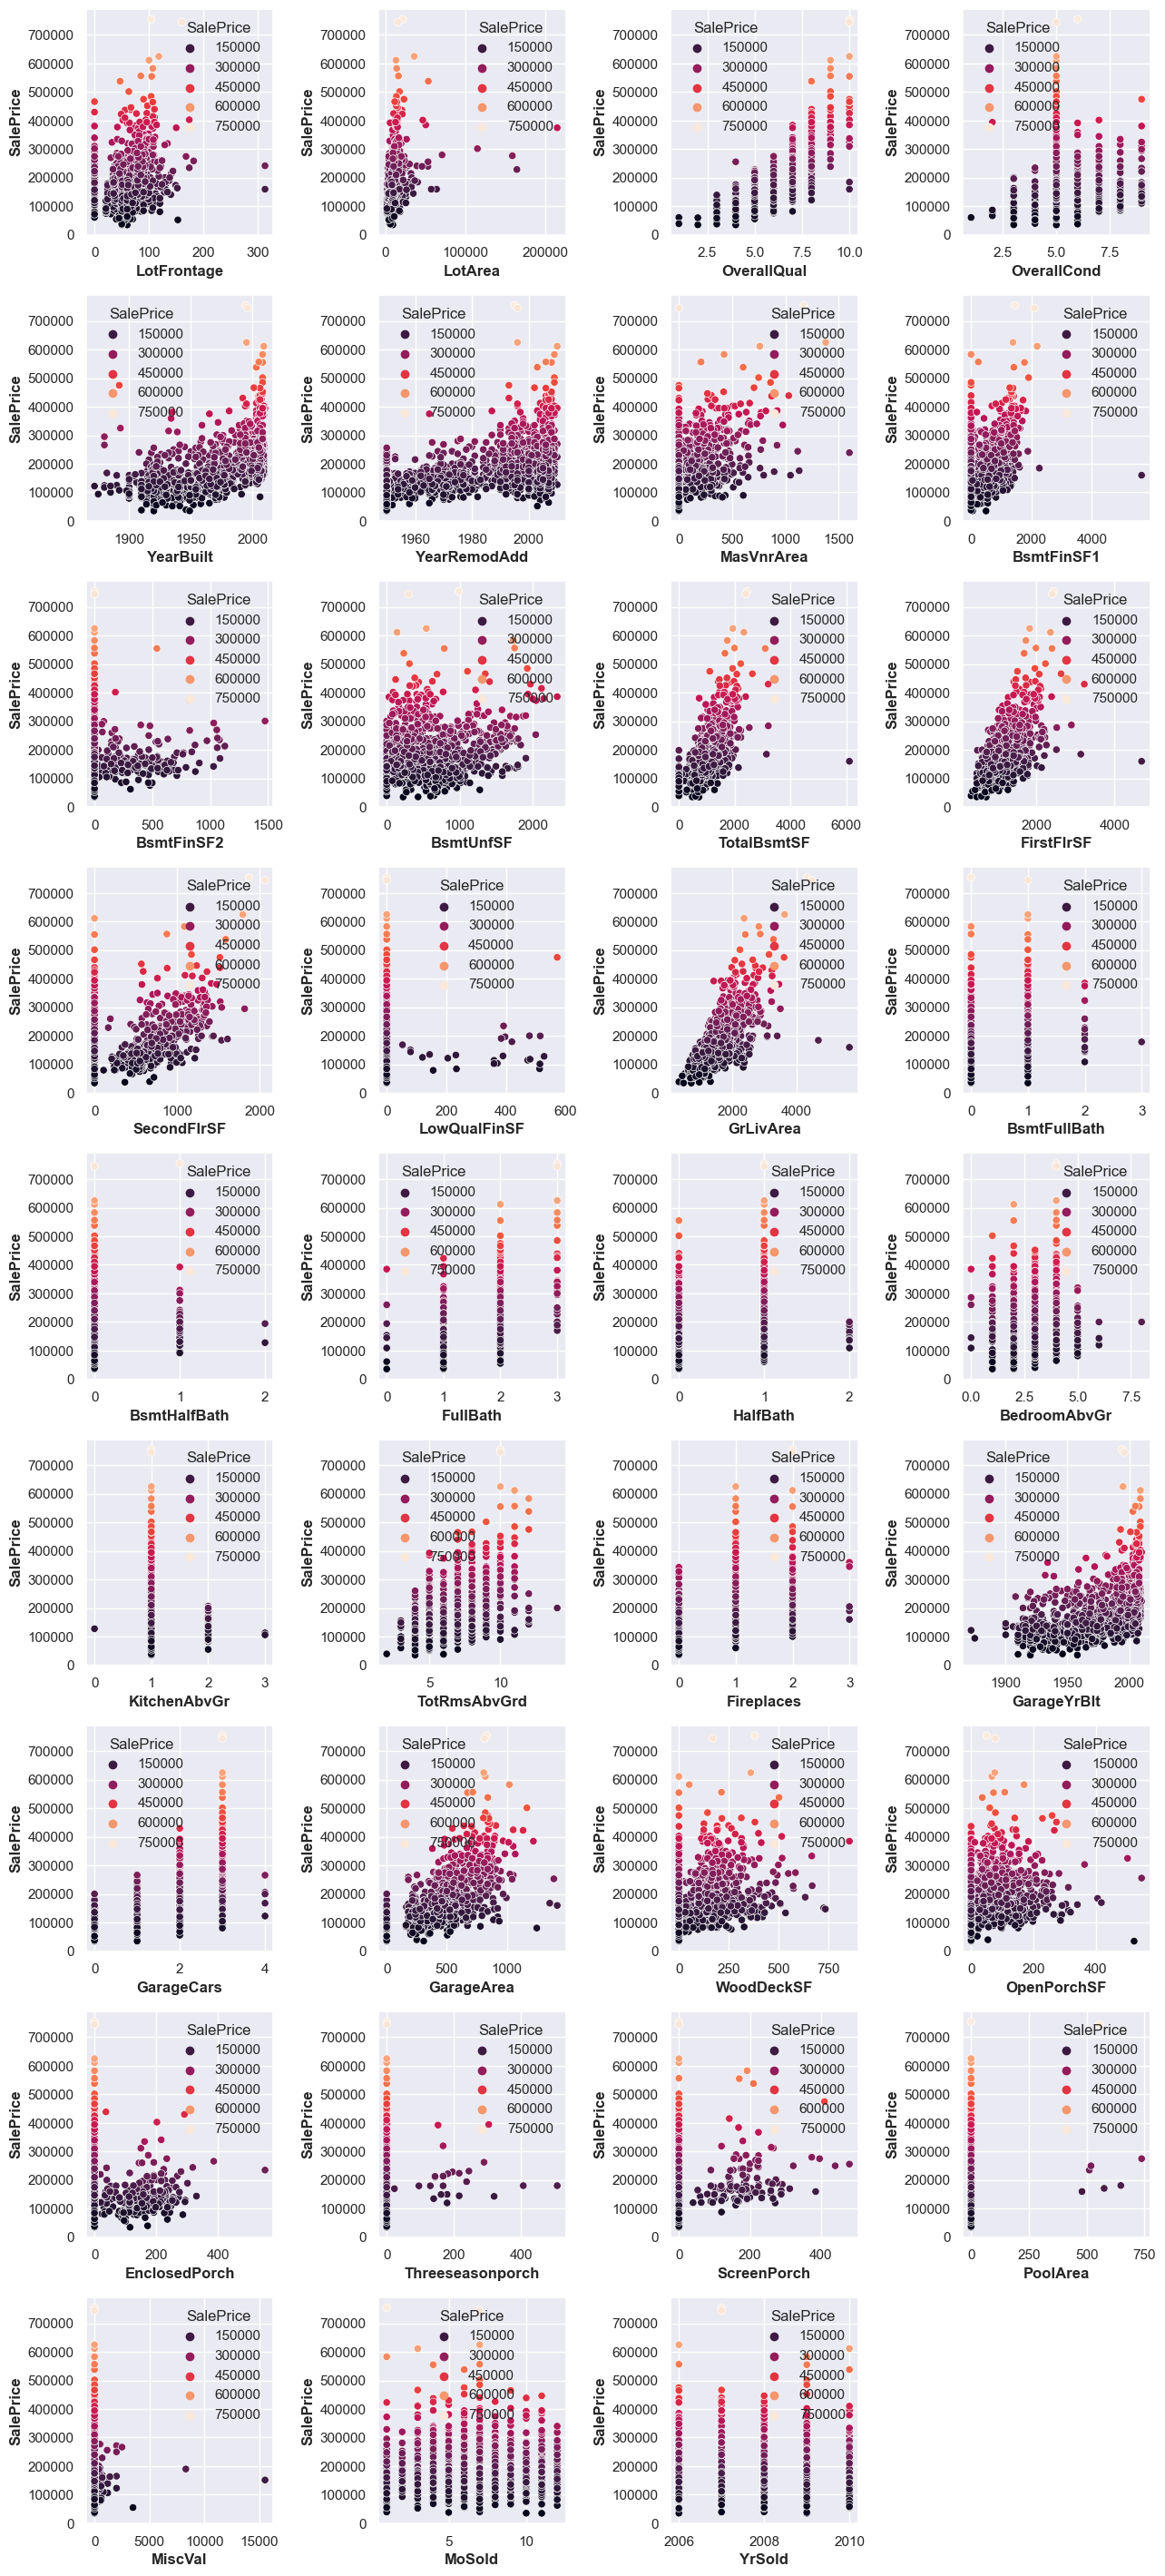

In [12]:
fig, axs = plt.subplots( figsize=(13, 110))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(len(numeric_features), 4, i)
    sns.scatterplot(x=col, y='SalePrice', hue='SalePrice', palette="rocket", data=df_train)

### Root Mean Squared Logaritmic Error (RMSLE)

In [13]:
# As the metric for loss is RMSLE, we need to log-transform y
def rmsle(X, y, model=XGBRegressor()):
    X = X.copy()
    X = pd.get_dummies(X, drop_first=True)
    score = -cross_val_score(model, X, np.log1p(y), cv=5, scoring="neg_mean_squared_error")
    score = score.mean()
    score = np.sqrt(score)
    return score

In [14]:
%%time
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = rmsle(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.13858 RMSLE
CPU times: total: 8.83 s
Wall time: 2.48 s


This baseline score will help us to know the improvement of our predictions by further data processing and feature engineering. 

### Mutual Information Score

In [15]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes] 
    # defining all the integer (numeric) data types as discrete
    
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

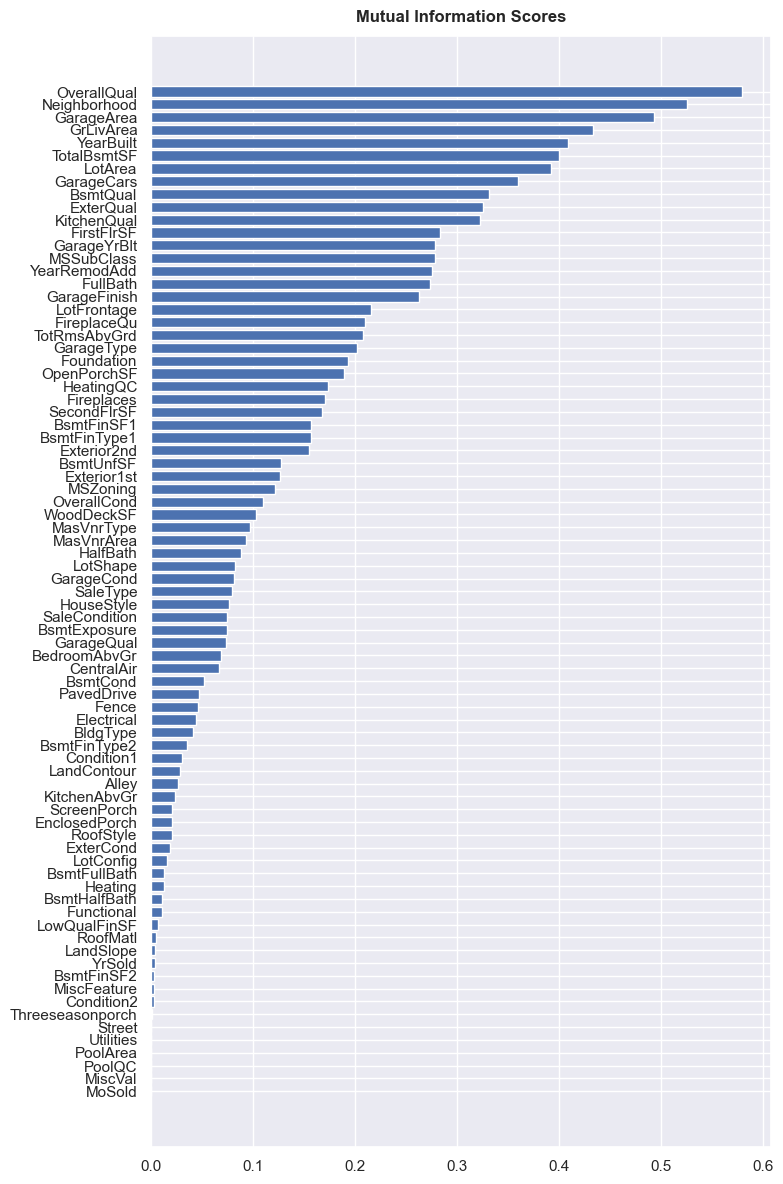

In [16]:
mi_scores = make_mi_scores(X, y) 
plt.figure(figsize=(8, 12))
plot_mi_scores(mi_scores)

The above plot gives us some insight on the mutual information between the target 'SalePrice' and the continuous and discrete features. 

### Feature types
There are many kinds of features we can consider to introduce for this dataset e.g. mathmatical features, logarithmic features, interaction features, transform features and others. Here we will briefly investigate the interactions between the features `GrLivArea`, `BldgType` and `Neighborhood`. While `GrLivArea` and `Neighborhood` scored highly in the MI scores, `BldgType` performed poorly. However, we should note that a feature (regardless has high or low MI score) can have interactions with other features and can thus be informative. It makes sense that the type of a dwelling and neighborhood should have effects on `GrLivArea` (Above ground living area) of the dwelling. We'll plot the variablitiy/trend of `SalePrice` for `GrLivArea` against different types of `BldgType` and `Neighborhood`. If there is significant variability in the `SalePrice` trend then there are interaction effects. We can include the interactions as new features in our model. 

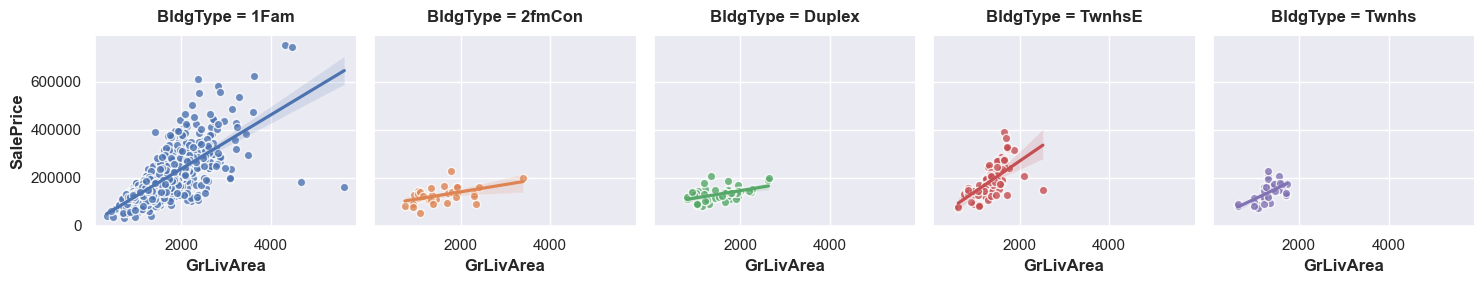

In [17]:
feature = "GrLivArea"

sns.lmplot(x=feature, y="SalePrice", hue="BldgType", col="BldgType",
           data=df_train, scatter_kws={"edgecolor": 'w'}, col_wrap=5, height=3);
plt.tight_layout()
plt.show()

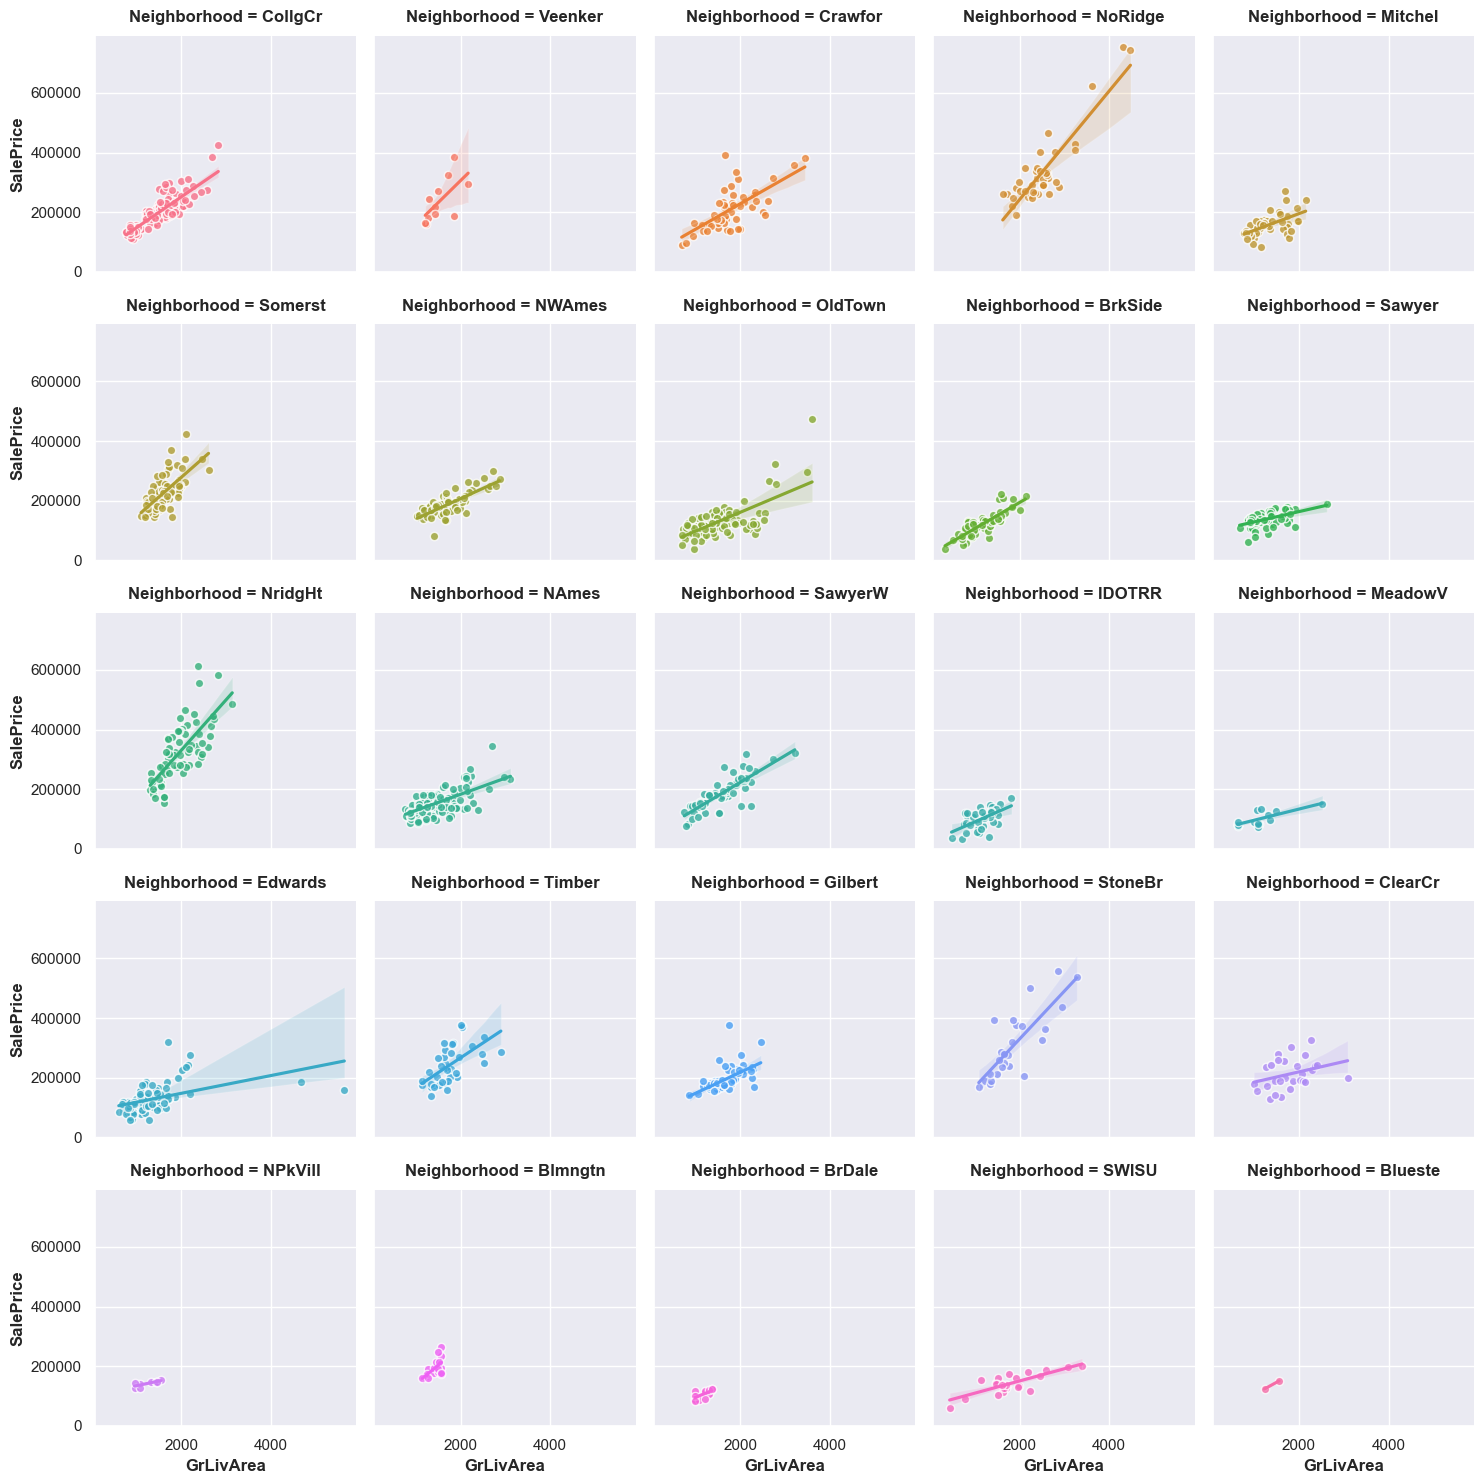

In [18]:
sns.lmplot(x=feature, y="SalePrice", hue="Neighborhood", col="Neighborhood",
           data=df_train, scatter_kws={"edgecolor": 'w'}, col_wrap=5, height=3);
plt.show()

Some features have skewed distribution. Converting them to log scale can help achieve normal distribution and act as new features. 

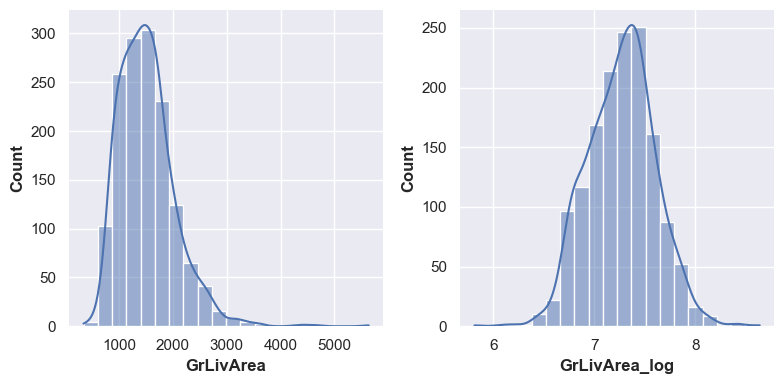

In [19]:
# Set up the matplotlib figure
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=False)
sns.despine(left=True, bottom=True)

# Plot histogram 
sns.histplot(df_train['GrLivArea'], kde=True, color="b", bins = 20, ax=axes[0])
sns.histplot(np.log1p(df_train['GrLivArea']), kde=True, color="b",  bins = 20, ax=axes[1])

axes[1].set_xlabel('GrLivArea_log')
plt.show()

### Create Features 

In [20]:
def create_features_pandas(df):
    
    X = df.copy()
    
    # mathematical_transforms:
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    X['NewHouse_RecentRemodel'] = 2*(df['YearBuilt']/2010) + (df['YearRemodAdd'] - df['YearBuilt'])/2010 
                                  # check the plot for 'SAlePrice' vs 'YearBuilt' and 'YearRemodAdd' in section B
        
    X['TotalSF'] = df['TotalBsmtSF'] + df['FirstFlrSF'] + df['SecondFlrSF'] 
    X['TotalSF2'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['FirstFlrSF'] + df['SecondFlrSF']
    X['TotalBathrooms'] = df['FullBath'] + (0.5*df['HalfBath']) + df['BsmtFullBath'] + (0.5*df['BsmtHalfBath'])
    X['TotalPorchArea'] = df['OpenPorchSF'] + df['Threeseasonporch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']
    
    X["OverallGrade"] = np.sqrt(df["OverallQual"] * df["OverallCond"])
    X["GarageGrade"] = np.sqrt(df["GarageQual"] * df["GarageCond"])
    X["ExterGrade"] = np.sqrt(df["ExterQual"] * df["ExterCond"])
    
    # special features
    X['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)                                                                          
    X['Has2ndfloor'] = df['SecondFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    X['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    X['HasBasement'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    X['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    X["HasShed"] = (df["MiscFeature"] == "Shed") * 1 
    X["RemodelbeforeSold"] = (df["YearRemodAdd"] == df["YrSold"])*1  # True(1) if a remodelling happened in the same year the house was sold
    
    X.loc[df.Neighborhood == 'NridgHt', "GoodNeighborhood"] = 1
    X.loc[df.Neighborhood == 'Crawfor', "GoodNeighborhood"] = 1
    X.loc[df.Neighborhood == 'StoneBr', "GoodNeighborhood"] = 1
    X.loc[df.Neighborhood == 'Somerst', "GoodNeighborhood"] = 1
    X.loc[df.Neighborhood == 'NoRidge', "GoodNeighborhood"] = 1
    X["GoodNeighborhood"].fillna(0, inplace=True)

    X["AbnormalSaleCondition"] = df.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0}) 
    X["PartialSale"] = df.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1}) 
    X["GoodHeating"] = df.HeatingQC.replace({'Ex': 1, 'Gd': 1, 'TA': 0, 'Fa': 0, 'Po': 0})

    area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', 'Threeseasonporch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea']
    X["TotalHouseArea"] = df[area_cols].sum(axis=1) 

    X["TotalArea1st2nd"] = df["FirstFlrSF"] + df["SecondFlrSF"]
    X["HouseAge"] = 2010 - df["YearBuilt"]
    X['SoldAge'] = df.YrSold - df.YearBuilt
       
    neighborhood = {"MeadowV" : 0,  "IDOTRR" : 1, "BrDale" : 1, "OldTown" : 1, "Edwards" : 1, "BrkSide" : 1, "Sawyer" : 1, 
                    "Blueste" : 1, "SWISU" : 2, "NAmes" : 2,  "NPkVill" : 2, "Mitchel" : 2, "SawyerW" : 2, "Gilbert" : 2, 
                    "NWAmes" : 2, "Blmngtn" : 2, "CollgCr" : 2, "ClearCr" : 3, "Crawfor" : 3, "Veenker" : 2, "Somerst" : 3, 
                    "Timber" : 3, "StoneBr" : 3, "NridgHt" : 3, "NoRidge" : 4}

    X["NeighborhoodMap"] = df["Neighborhood"].map(neighborhood)
    

    # logarithmic features from highly skewed features
    X["GrLivArea_log"] = np.log1p(df.GrLivArea)
    X['MasVnrArea_log'] = np.log1p(df.MasVnrArea)


    # interaction features
    X1 = pd.get_dummies(df.BldgType, prefix="BldgType_Interaction")
    X1 = X1.mul(df.GrLivArea, axis=0)
    
    X2 = pd.get_dummies(df.Neighborhood, prefix="Neighborhood_Interaction")
    X2 = X2.mul(df.GrLivArea, axis=0)
    
    X = X.join(X1)
    X = X.join(X2)

    
    # counts features
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)


    # group_transforms features
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
  
    return X


df_train = create_features_pandas(df_train)

In [21]:
X = df_train.copy()
y = X.pop("SalePrice")

score = rmsle(X, y)
print(f"Score (CV): {score:.5f} RMSLE")

Score (CV): 0.13713 RMSLE


### Additional Features from Principal Component Analysis (PCA)
PCA is an unsupervised machine learning technique that can be used for creating features. The PCA algorithm can decompose the variational structure within the features, give us loadings which describe each component of variation, and also the components which are the transformed datapoints. The loadings can suggest features to create and the components we can use as features directly. 

In [22]:
# Fit scikit-learn's PCA estimator and create the principal components
def apply_pca(X, standardize=True):
    # Standardize the data when the selected features aren't naturally on the same scale.
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


# Plot the variation captured by the the signs and magnitudes of a component's loadings
def plot_variance(pca):
    # Create figure
    fig, axs = plt.subplots(1, 2, figsize = (10, 5))
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.05))
    
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(-0.02, 1.02))
    axs[0].set_ylim(0,1.05)
    # Set up figure
    return axs


In [23]:
pca_features = ['YearRemodAdd', 'TotalBsmtSF', 'GrLivArea']

X = df_train.copy()
X = X.loc[:, pca_features]

pca, X_pca, loadings = apply_pca(X)
loadings

,PC1,PC2,PC3
YearRemodAdd,0.506972,-0.861909,-0.009594
TotalBsmtSF,0.610309,0.351077,0.710118
GrLivArea,0.608689,0.365865,-0.704018


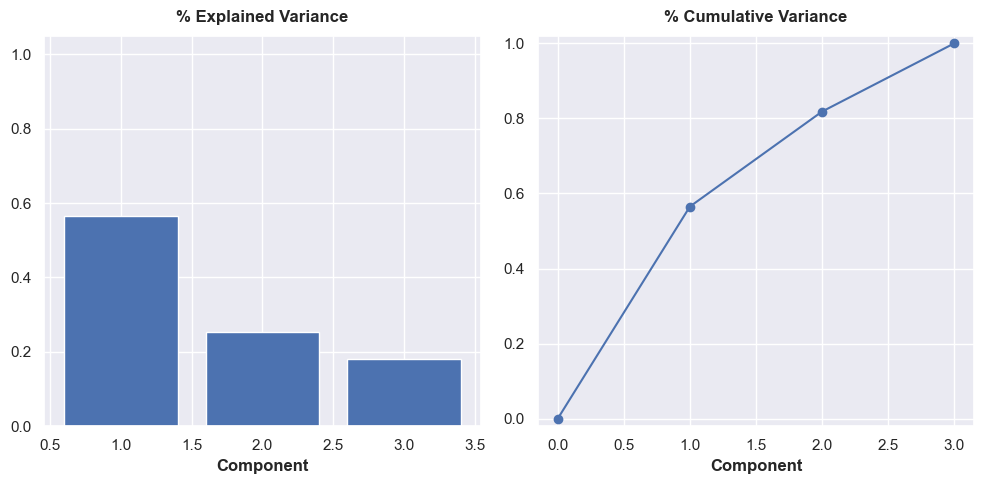

In [24]:
plot_variance(pca);

In [25]:
mi_scores = make_mi_scores(X_pca, y)
mi_scores

PC1    0.800267
PC3    0.340579
PC2    0.209341
Name: MI Scores, dtype: float64

**A correlation matrix for the dataset can help finding new features! We can search for highly correlated features and apply PCA.**

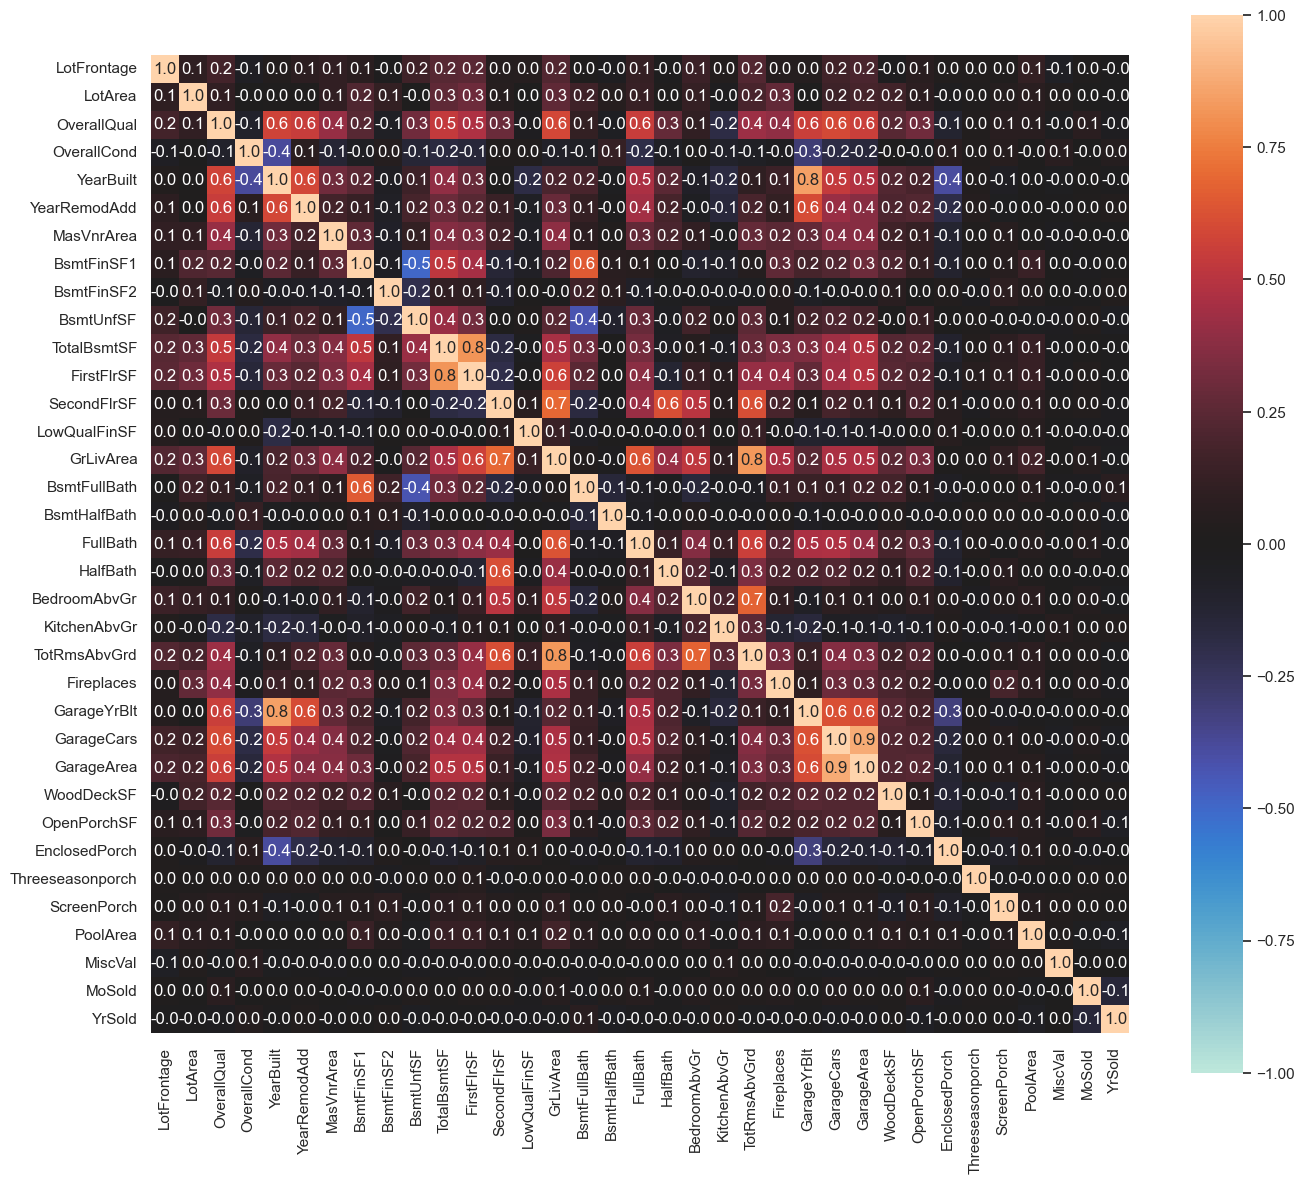

In [26]:
def corrplot(df, method="pearson"):
    corr = df.corr(method)
    plt.subplots(figsize=(14,12))
    sns.heatmap(corr, vmin=-1.0, vmax=1.0, cmap="icefire", square=True, annot=True, fmt=".1f") # cmap="Blues"   
    
X = df_train.copy()
y = X.pop("SalePrice")   
corrplot(X[numeric_features], method="pearson")

In [27]:
# Select highly correlated features as seen in the correlation plot and apply PCA 
pca_features2 = ['FullBath', 'FirstFlrSF', 'SecondFlrSF', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'GrLivArea']

X = df_train.copy()
X = X.loc[:, pca_features2]

# `apply_pca`, defined above, reproduces the code from the tutorial
pca2, X_pca2, loadings2 = apply_pca(X)
loadings2

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
FullBath,0.388377,0.089598,0.057532,-0.909435,-0.036068,0.097151,0.003819
FirstFlrSF,0.310710,-0.420994,0.635974,0.110642,0.241857,-0.085545,-0.493666
SecondFlrSF,0.284178,0.612029,-0.321452,0.142251,0.329827,-0.034139,-0.557803
TotRmsAbvGrd,0.415006,0.290409,0.244309,0.261620,-0.779330,0.088544,-0.010238
GarageCars,0.379841,-0.372442,-0.463272,0.028345,-0.150992,-0.691836,0.012131
GarageArea,0.371316,-0.416292,-0.411836,0.164349,0.048228,0.699909,-0.002663
GrLivArea,0.466348,0.209301,0.212081,0.210219,0.446025,-0.075685,0.666990


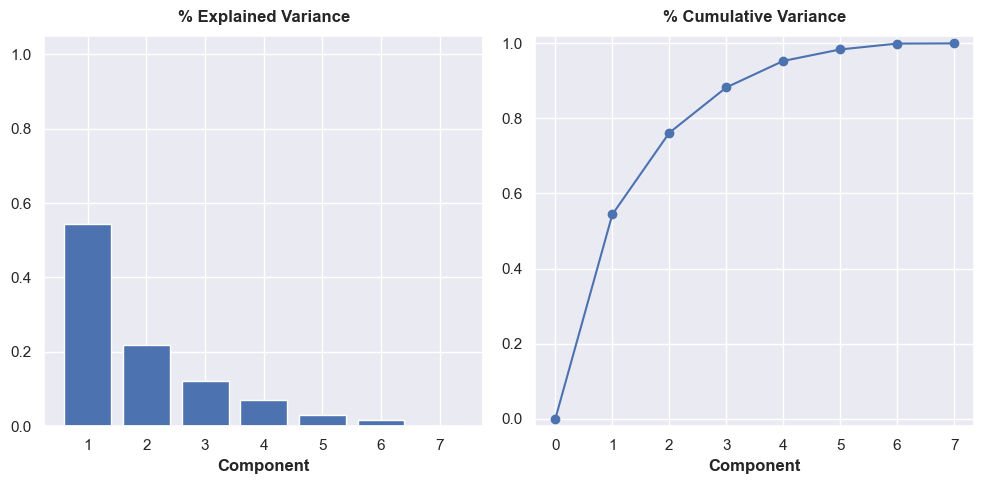

In [28]:
plot_variance(pca2);

In [29]:
mi_scores2 = make_mi_scores(X_pca2, y)
mi_scores2

PC1    0.667084
PC4    0.276402
PC2    0.227001
PC7    0.165142
PC6    0.054360
PC3    0.052895
PC5    0.052686
Name: MI Scores, dtype: float64

In [30]:
# Create New Features inspired by the loadings of the principal components
def pca_inspired(df):
    X = df.copy()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF 
    X["Feature2"] = np.sqrt(df.YearRemodAdd * df.TotalBsmtSF)
    X["Feature3"] = df.GrLivArea * df.TotRmsAbvGrd 
    X["Feature4"] = np.sqrt(df.GrLivArea * df.FirstFlrSF)
    X["Feature5"] = np.sqrt(df.GarageCars * df.GarageArea)
    X["Feature6"] = np.sqrt(df.GrLivArea * df.FullBath)
    X["Feature7"] = np.sqrt(df.GrLivArea * df.SecondFlrSF)
   
    return X

df_train = pca_inspired(df_train)

X = df_train.copy()
y = X.pop("SalePrice")

score = rmsle(X, y)
print(f"Score (CV): {score:.5f} RMSLE")

Score (CV): 0.13562 RMSLE


In [31]:
print(df_train.shape)

(1460, 147)


# B. Complete preprocessing step

### Initial preprocessing and feature creation

In [32]:
def preprocess(df):
    
    X = df.copy()
    
    # clean X
    X = clean(X)
    
    # ordinal encode X
    X = ordinal_encode(X)
    
    # nominal encode X
    X = nominal_encode(X)
    
    # impute NAs
    X = impute(X)
    
    # factorize ordered categorical features
    X = label_encode(X)
    
    # create features with pandas
    X = create_features_pandas(X)
    
    # create features from PCA analysis
    X = pca_inspired(X)
    
    return X


In [33]:
X_train = train.copy()
y_train = X_train.pop("SalePrice")
X_train = preprocess(X_train)
print(X_train.shape)

(1460, 146)


In [34]:
X_test = test.copy()
X_test = preprocess(X_test)
print(X_test.shape)

(1459, 146)


### Scale numeric data and one-hot encode nominal categorical features

In [35]:
# transformer/scaler for numeric features
numeric_transformer = RobustScaler()

# one-hot encoding for nominal categorical features
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

numeric_cols = X_train.select_dtypes(exclude=['object']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

pipeline = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [36]:
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [37]:
print(X_train.shape)
print(X_test.shape)

(1460, 279)
(1459, 279)


### Re-evaluate model with RMSLE
As the categorical data are already one hot encoded, we do not need to encode again inside the function!

In [38]:
def rmsle(X, y, model=XGBRegressor()):
    X = X.copy()
    # X = pd.get_dummies(X, drop_first=True)
    score = -cross_val_score(model, X, np.log1p(y), cv=5, scoring="neg_mean_squared_error")
    score = score.mean()
    score = np.sqrt(score)
    return score

In [39]:
score = rmsle(X_train, y_train)
print(f"Score (CV): {score:.5f} RMSLE")

Score (CV): 0.13551 RMSLE


# C. Create Stacking model for improved prediction
Stacking is an ensemble machine learning technique in which the outputs of multiple different machine learning models (base models) are fed into a higher-level meta-model to make the final output. Stacking can be useful to improve the overall accuracy of the predictions by utilising the strengths of each individual base model and minimising the effects of overfitting. 

### Hyperparameter Tuning
Hyperparameter tuning for XGB and Gradient Boosting Regressor was performed with Optuna. Please check the code below for your own hyperparameters search.

In [40]:
# # Optuna with XGBoost: Hyperparameter Tuning

# import optuna

# def objective(trial):
#     xgb_params = dict(
#         max_depth=trial.suggest_int("max_depth", 2, 10),
#         learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
#         n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
#         min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
#         colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
#         subsample=trial.suggest_float("subsample", 0.2, 1.0),
#         reg_alpha=trial.suggest_float("reg_alpha", 1e-3, 1, log=True),
#         reg_lambda=trial.suggest_float("reg_lambda", 1e-3, 1, log=True),
#     )
#     xgb = XGBRegressor(**xgb_params)
#     return rmsle(X_train, y_train, xgb)

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=100)
# study.best_params


### XGB Regressor

In [41]:
# XGB Regressor
xgb_params = dict(max_depth= 4,
                  learning_rate= 0.005005070416155941,
                  n_estimators= 7650,
                  min_child_weight= 2,
                  colsample_bytree= 0.20263034530849983,
                  subsample= 0.4402289758648288,
                  reg_alpha= 0.0010309970136600966,
                  reg_lambda= 0.012884368300273313,
                  random_state=1)
                  

xgb =  XGBRegressor(**xgb_params)

### Gradient Boosting Regressor

In [42]:
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=5211, 
                                learning_rate=0.009636280613755809, 
                                max_depth=4, 
                                max_features='sqrt', 
                                min_samples_leaf=5, 
                                min_samples_split=9, 
                                loss='huber', 
                                random_state=1)    

### Ridge

In [43]:
ridge = Ridge(alpha = 6, random_state=1)

### ElasticNet

In [44]:
elasticnet = ElasticNet(max_iter=1000,
                        alpha=0.0007,
                        l1_ratio=0.9,
                        random_state=1)

### Define Stack Model

In [45]:
base_models = [('ridge', ridge),
              ('elasticnet', elasticnet),
              # ('gbr', gbr),
              ('xgb', xgb)]

meta_model = LinearRegression()

stack = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv = 5)

### Evaluate and compare the score of the different models 

In [46]:
%%time

print('score comparison of all the models:')
score = rmsle(X_train, y_train, xgb)
print("xgb score: {:.5f}".format(score))

score = rmsle(X_train, y_train, gbr)
print("gbr score: {:.5f}".format(score))

score = rmsle(X_train, y_train, ridge)
print("ridge score: {:.5f}".format(score))

score = rmsle(X_train, y_train, elasticnet)
print("elasticnet score: {:.5f}".format(score))

score = rmsle(X_train, y_train, stack)
print("stack score: {:.5f}".format(score))

score comparison of all the models:
xgb score: 0.11466
gbr score: 0.11736
ridge score: 0.12259
elasticnet score: 0.12065
stack score: 0.11401
CPU times: total: 22min 30s
Wall time: 8min 45s


### Fit stacking model to full training data

In [47]:
%%time

print('fitting started:')
stack_model = stack.fit(X_train, np.log(y_train))
print('stack: done')

fitting started:
stack: done
CPU times: total: 4min 8s
Wall time: 1min 10s


### Make predictions

In [48]:
# As the y was log-transformed during fitting/training the model, we need to exp-transform the predictions
predictions = np.exp(stack_model.predict(X_test))
output = pd.DataFrame({'Id': test.index, 'SalePrice': predictions})
output.to_csv('Test_prediction.csv', index=False)
print(output.head())

     Id      SalePrice
0  1461  122444.655775
1  1462  160725.095123
2  1463  183188.937954
3  1464  197624.120020
4  1465  187444.159384


In [50]:
time_end = time.time()
print("Notebook run time: {:.0f} seconds".format(time_end - time_start))

Notebook run time: 801 seconds
